# Install opencv-contrib-python, extract dataset and import libraries needed
## Install opencv-contrib-python

In [2]:
!pip uninstall opencv-python -y
!pip install opencv-contrib-python==3.4.2.17 --force-reinstall

Found existing installation: opencv-python 4.1.2.30
Uninstalling opencv-python-4.1.2.30:
  Successfully uninstalled opencv-python-4.1.2.30
     |████████████████████████████████| 30.6 MB 57 kB/s 
     |████████████████████████████████| 15.7 MB 497 kB/s 
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
  Attempting uninstall: opencv-contrib-python
    Found existing installation: opencv-contrib-python 4.1.2.30
    Uninstalling opencv-contrib-python-4.1.2.30:
      Successfully uninstalled opencv-contrib-python-4.1.2.30
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
imgaug 0.2.9 requires opencv-python, which is not installed.
dopamine-rl 1.0.5 requires opencv-python>=3.4.1.15, which is not installed.
albumentations 0.1.12 requires opencv-python, which is not ins

## Extract dataset and change current working directory
For the purpose of the project, you need to download the data "project-data.zip".

Here is the link of our GitHub repository : https://github.com/RealAcharnes/computer-vision-authentication.git

In [1]:
from zipfile import ZipFile
file_name = "/content/project-data1.zip"

with ZipFile(file_name, 'r') as zipfile:
  zipfile.extractall()
  print('Extraction done')

Extraction done


## Import all the librairies needed

In [2]:
import cv2
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy.cluster.vq import *
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.utils import shuffle
from sklearn.svm import SVC
import joblib

## Define utility function

In [3]:
def imlist(path):
      """
      The function imlist returns all the names of the files in 
      the directory path supplied as argument to the function.
      """
      return [os.path.join(path, f) for f in os.listdir(path)]

# Test on SURF algorithm
The following cells are only for test of the SURF algorythm.

They are usefull to understand how works the algoythm in the next training and testing cells.

In [4]:
# Create SURF object. You can specify params here or later.
# Here I set Hessian Threshold to 800 for test
surf = cv2.xfeatures2d.SURF_create(800)
# We allow surf algorythm to use descriptors of size 128, to get more details.
surf.setExtended(True)

Number of keypoints : 30
Shape of descriptors : (30, 128)


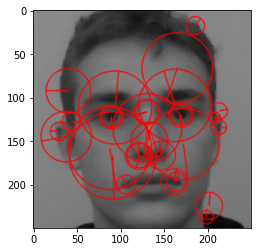

In [5]:
# First we get the descriptors of first image then we draw them on the image to display

img1 = cv2.imread('./dataset1/train/Alexis/Alexis12.jpg', 0)

# Find keypoints and descriptors directly
kp1, des1 = surf.detectAndCompute(img1, None)
print("Number of keypoints :", len(kp1))
print("Shape of descriptors :", des1.shape)

# Draw keypoints
img1 = cv2.drawKeypoints(img1, kp1, None, (255,0,0), 4)
plt.imshow(img1)
plt.show()

Number of keypoints : 43
Shape of descriptors : (43, 128)


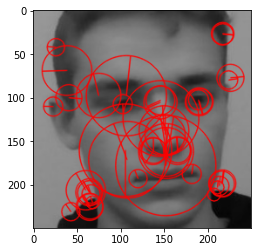

In [6]:
# We get the descriptors of sccond image then we draw them on the image to display

img2 = cv2.imread('./dataset1/train/Alexis/Alexis11.jpg', 0)

# Find keypoints and descriptors directly
kp2, des2 = surf.detectAndCompute(img2, None)
print("Number of keypoints :", len(kp2))
print("Shape of descriptors :", des2.shape)

# Draw keypoints
img2 = cv2.drawKeypoints(img2, kp2, None, (255,0,0), 4)
plt.imshow(img2)
plt.show()

Now we display the matching of the descriptors of the 2 images.

We use BruteForce for the matcher and knnMatch for the matching.

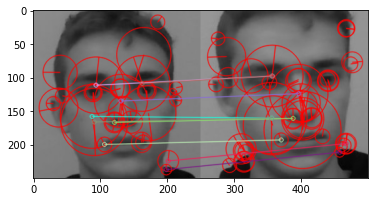

In [7]:
# BFMatcher with default params
bf = cv2.BFMatcher(cv2.NORM_L2)
matches = bf.knnMatch(des1, des2, k=2)

# Apply ratio test
good = []
for m, n in matches:
    if m.distance < 0.75*n.distance:
        good.append([m])

# cv.drawMatchesKnn expects list of lists as matches.
img3 = cv2.drawMatchesKnn(img1, kp1, img2, kp2, good, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.imshow(img3)
plt.show()

# Train phase

For this project we use SURF algorythm to describe all our train dataset with descriptors. Then, we perform kmean clustering on all these descriptors of every images. This gives us a vocabulary of k visual bag of words.

Thanks to this bag of visual words we can calculate the histogram of features.

Finally, we train a model of SVM for the classification anb o authenticate people.

The hyperparameters we can finetune are :

*   The Hessian Threshold (for the SURF algorythm)
*   k (the number  of visual words in the vocabulary)
*   The kernel of the SVM : 'linear' or 'rbf', it specifies the kernel type to be used in the algorithm.
*   C : the regularization parameter for SVM. The strength of the regularization is inversely proportional to C.

To find the perfect match of these parameters during the training in our case, we use GridSearchCV for the kernel and for C parameters and we loop through a range of different Hessian Thresholds and Regularization parameters.



In [8]:
# Define the hessian threshold used for SURF algorithm
hessian_thresholds = [10, 25, 50, 100, 200, 400, 800, 1600, 2400]
ks = [20, 50, 100, 200, 400, 800]

In [9]:
def train_gridsearch(hessian_threshold, k):
  # Get the path of the training set
  train_path = './dataset1/train'

  # Get the training classes names and store them in a list
  training_names = os.listdir(train_path)

  # Get all the path to the images and save them in a list
  # image_paths and the corresponding label in image_paths
  image_paths = []
  image_classes = []
  class_id = 0
  for training_name in training_names:
      dir = os.path.join(train_path, training_name)

      class_path = imlist(dir)
      image_paths += class_path
      image_classes += [class_id] * len(class_path)
      class_id += 1

##################################################################################

  # Create feature extraction and keypoint detector objects
  des_list = []

  # Create SURF object. You can specify params here or later.
  surf = cv2.xfeatures2d.SURF_create(hessian_threshold)
  surf.setExtended(True)
  image_paths, image_classes = shuffle(image_paths, image_classes, random_state=17)

  for image_path in image_paths:
      im = cv2.imread(image_path)
      gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
      kp, des = surf.detectAndCompute(gray, None)
      des_list.append((image_path, des))

###################################################################################

  # Stack all the descriptors vertically in a numpy array
  descriptors = des_list[0][1]
  for image_path, descriptor in des_list[1:]:
      descriptors = np.vstack((descriptors, descriptor))

####################################################################################

  # Perform k-means clustering
  # print ("Start k-means: %d words, %d key points" % (k, descriptors.shape[0]))
  voc, variance = kmeans(descriptors, k, 1)

  # Calculate the histogram of features
  im_features = np.zeros((len(image_paths), k), "float32")
  for i in range(len(image_paths)):
      words, distance = vq(des_list[i][1], voc)
      for w in words:
          im_features[i][w] += 1

###################################################################################

  # Fit scaler and scale the features
  stdSlr = StandardScaler().fit(im_features)
  im_features = stdSlr.transform(im_features)

###################################################################################

  # Parameters for grid search
  parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}
  # Train the Linear SVM
  svc = SVC()
  clf = GridSearchCV(svc, parameters)
  clf.fit(im_features, np.array(image_classes))

##################################################################################

  print(f"Hessian Threshold : {hessian_threshold},  k : {k}")
  print(f"\t Best parameters : {clf.best_params_}")
  print(f"\t Best score : {clf.best_score_}")

  return (clf.best_params_, clf.best_score_, clf, training_names, stdSlr, k, voc)

In [10]:
best_total_score = 0
for hessian_threshold in hessian_thresholds:
  for k in ks:
    best_params, best_score, clf, training_names, stdSlr, k, voc = train_gridsearch(hessian_threshold, k)
    if best_score > best_total_score:
      best_total_score = best_score
      best_total_param = best_params
      best_k = k
      best_hessian_threshold = hessian_threshold

Hessian Threshold : 10,  k : 20
	 Best parameters : {'C': 1, 'kernel': 'rbf'}
	 Best score : 0.8967320261437909
Hessian Threshold : 10,  k : 50
	 Best parameters : {'C': 10, 'kernel': 'rbf'}
	 Best score : 0.9660130718954247
Hessian Threshold : 10,  k : 100
	 Best parameters : {'C': 10, 'kernel': 'rbf'}
	 Best score : 0.9313725490196078
Hessian Threshold : 10,  k : 200
	 Best parameters : {'C': 1, 'kernel': 'linear'}
	 Best score : 0.9888888888888889
Hessian Threshold : 10,  k : 400
	 Best parameters : {'C': 1, 'kernel': 'linear'}
	 Best score : 0.9888888888888889
Hessian Threshold : 10,  k : 800
	 Best parameters : {'C': 1, 'kernel': 'linear'}
	 Best score : 1.0
Hessian Threshold : 25,  k : 20
	 Best parameters : {'C': 1, 'kernel': 'rbf'}
	 Best score : 0.9196078431372549
Hessian Threshold : 25,  k : 50
	 Best parameters : {'C': 1, 'kernel': 'rbf'}
	 Best score : 0.9437908496732026
Hessian Threshold : 25,  k : 100
	 Best parameters : {'C': 10, 'kernel': 'rbf'}
	 Best score : 0.9666666

After we found the best parameters (can take few minutes), we display them. Then we finally train a model with these parameters.

In [11]:
# We display what are the best parameters we found
print("Best parameters found :")
print(f"Hessian Threshold : {best_hessian_threshold}")
print(f"K (number of word) : {best_k}")
print(f"Best parameters for SVM : {best_total_param}")
print(f"Best score reached with these parameters : {best_total_score}")

Best parameters found :
Hessian Threshold : 10
K (number of word) : 800
Best parameters for SVM : {'C': 1, 'kernel': 'linear'}
Best score reached with these parameters : 1.0


In [12]:
# To train a model with the best parameters found
best_params, best_score, clf, training_names, stdSlr, k, voc = train_gridsearch(best_hessian_threshold, best_k)

# To save the model
joblib.dump((clf, training_names, stdSlr, k, voc), "svm_model2.pkl", compress=3)

Hessian Threshold : 10,  k : 800
	 Best parameters : {'C': 1, 'kernel': 'linear'}
	 Best score : 0.977124183006536


['svm_model2.pkl']

# Test phase
In this phase we test the model on new data it has never seen before and calculate accuracy to demonstrate how efficient our model is.

In [13]:
# Model loading
clf, classes_names, stdSlr, k, voc = joblib.load("svm_model2.pkl")

In [14]:
# Dict to get label from name
name_to_label = {}
for i, j in enumerate(classes_names):
    name_to_label[j] = i

In [15]:
image_paths = []
test_path = './dataset1/test'
testing_names = os.listdir(test_path)
for testing_name in testing_names:
    dir = os.path.join(test_path, testing_name)
    class_path = imlist(dir)
    image_paths += class_path

In [16]:
# Create feature extraction and keypoint detector objects
des_list = []

# Create SURF object. You can specify params here or later.
surf = cv2.xfeatures2d.SURF_create(best_hessian_threshold)
surf.setExtended(True)
image_paths = shuffle(image_paths, random_state=18)
label_test = [name_to_label[image_path.split("/")[-2]] for image_path in image_paths]

# calcul des descripteurs SURF
for image_path in image_paths:
    im = cv2.imread(image_path)
    gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    kp, des = surf.detectAndCompute(gray, None)
    des_list.append((image_path, des))

# Stack all the descriptors vertically in a numpy array
descriptors = des_list[0][1]
for image_path, descriptor in des_list[1:]:
    descriptors = np.vstack((descriptors, descriptor))

# Calculate the histogram of features
test_features = np.zeros((len(image_paths), k), "float32")
for i in range(len(image_paths)):
    words, distance = vq(des_list[i][1], voc)
    for w in words:
        test_features[i][w] += 1

In [17]:
# Scale the features
test_features = stdSlr.transform(test_features)

# Perform the predictions
# If you want directly the name predicted, uncomment the next line
# predictions = [classes_names[i] for i in clf.predict(test_features)]

predictions = clf.predict(test_features)

In [18]:
# To calculate accuracy on test dataset
accuracy = accuracy_score(label_test, predictions)
print("Accuracy :", accuracy)

Accuracy : 1.0


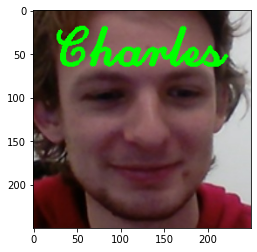

In [19]:
# Visualize the results
for image_path, prediction in zip(image_paths, predictions):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # cv2.namedWindow("Image", cv2.WINDOW_NORMAL)
    pt = (25, 1 * image.shape[0] // 4)
    cv2.putText(image, classes_names[prediction], pt, cv2.FONT_HERSHEY_SCRIPT_COMPLEX, 2, [0, 255, 0], 4)
    plt.imshow(image)

# Define function to get image from camera with google colab

In [20]:
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  data = data.split(',')[1]
  img = cv2.imdecode(np.frombuffer(b64decode(data), np.uint8), cv2.IMREAD_COLOR)
  
  return img

# Define function to automatically take 20 photos of the new user identity and add it to the database

In [21]:
def take_automatic_photo(firstname, quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      function delay(n){
        return new Promise(function(resolve){
          setTimeout(resolve,n*1000);
        });
      }
      await delay(3)

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  
  i = 0

  while (i < 20):
    display(js)
    data = eval_js('takePhoto({})'.format(quality))
    data = data.split(',')[1]
    img = cv2.imdecode(np.frombuffer(b64decode(data), np.uint8), cv2.IMREAD_COLOR)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    resized = face_detection_crop(gray, img)

    if resized is not False:
      i += 1
      cv2.imwrite(f"./dataset1/train/{firstname}/{firstname}{i}.jpg", resized)
      print(f"Photo {i} saved !")
    else:
      print("No faces found, photo not saved.")
  
  return

In [24]:
def face_detection_crop(gray_image, image):
  '''
  Detect faces on an image and crop it
  '''
  # Initialize the Haar Cascade face detection model 
  face_cascade = cv2.CascadeClassifier('Data-FaceDetection and Recognition/haarcascades/haarcascade_frontalface_default.xml')
  faces = face_cascade.detectMultiScale(image=gray_image, scaleFactor=1.3, minNeighbors=5)

  for (x,y,w,h) in faces:
      roi_color = image[y:y+h, x:x+w]
      resized = cv2.resize(src=roi_color, dsize=(250, 250))
  
  if len(faces) == 0:
    return False
  else:
    return resized 

# Add a new user user in the database and re-train the model
Here is the cell to add a new user in the database.

The user just have to write his name (be carefull it's case-sensitive), then 20 photos of him will be taken. The user has 3 seconds to change position between each photo.

Then we find the best parameters to train on the new dataset and we re-train the model !

Finally the new model is saved and you can load it later fo the use inference (real test).

In [27]:
firstname = input("20 photos will be taken in a row, each space by 2 secondes, after you enter your firstname.\nEnter your firstname : ")
os.mkdir(f"./dataset1/train/{firstname}")
take_automatic_photo(firstname)

# We found the best hyperparameters and we re-train the model with the new data 
best_total_score = 0
for hessian_threshold in hessian_thresholds:
  for k in ks:
    best_params, best_score, clf, training_names, stdSlr, k, voc = train_gridsearch(hessian_threshold, k)
    if best_score > best_total_score:
      best_total_score = best_score
      best_total_param = best_params
      best_k = k
      best_hessian_threshold = hessian_threshold

# To train a model with the best parameters found
best_params, best_score, clf, training_names, stdSlr, k, voc = train_gridsearch(best_hessian_threshold, best_k)

# To save the model
joblib.dump((clf, training_names, stdSlr, k, voc), "svm_model.pkl", compress=3)

20 photos will be taken in a row, each space by 2 secondes, after you enter your firstname.
Enter your firstname : Jean-Charles


<IPython.core.display.Javascript object>

Photo 1 saved !


<IPython.core.display.Javascript object>

Photo 2 saved !


<IPython.core.display.Javascript object>

Photo 3 saved !


<IPython.core.display.Javascript object>

Photo 4 saved !


<IPython.core.display.Javascript object>

Photo 5 saved !


<IPython.core.display.Javascript object>

Photo 6 saved !


<IPython.core.display.Javascript object>

Photo 7 saved !


<IPython.core.display.Javascript object>

Photo 8 saved !


<IPython.core.display.Javascript object>

Photo 9 saved !


<IPython.core.display.Javascript object>

Photo 10 saved !


<IPython.core.display.Javascript object>

Photo 11 saved !


<IPython.core.display.Javascript object>

Photo 12 saved !


<IPython.core.display.Javascript object>

Photo 13 saved !


<IPython.core.display.Javascript object>

Photo 14 saved !


<IPython.core.display.Javascript object>

Photo 15 saved !


<IPython.core.display.Javascript object>

Photo 16 saved !


<IPython.core.display.Javascript object>

Photo 17 saved !


<IPython.core.display.Javascript object>

Photo 18 saved !


<IPython.core.display.Javascript object>

Photo 19 saved !


<IPython.core.display.Javascript object>

Photo 20 saved !
Hessian Threshold : 10,  k : 20
	 Best parameters : {'C': 1, 'kernel': 'rbf'}
	 Best score : 0.7771241830065361
Hessian Threshold : 10,  k : 50
	 Best parameters : {'C': 10, 'kernel': 'rbf'}
	 Best score : 0.8483660130718954
Hessian Threshold : 10,  k : 100
	 Best parameters : {'C': 1, 'kernel': 'rbf'}
	 Best score : 0.8947712418300654
Hessian Threshold : 10,  k : 200
	 Best parameters : {'C': 10, 'kernel': 'rbf'}
	 Best score : 0.9071895424836601
Hessian Threshold : 10,  k : 400
	 Best parameters : {'C': 1, 'kernel': 'linear'}
	 Best score : 0.9183006535947712
Hessian Threshold : 10,  k : 800
	 Best parameters : {'C': 1, 'kernel': 'linear'}
	 Best score : 0.918954248366013
Hessian Threshold : 25,  k : 20
	 Best parameters : {'C': 10, 'kernel': 'rbf'}
	 Best score : 0.8130718954248366
Hessian Threshold : 25,  k : 50
	 Best parameters : {'C': 10, 'kernel': 'rbf'}
	 Best score : 0.8947712418300654
Hessian Threshold : 25,  k : 100
	 Best parameters : {'C': 1, 'kernel': 'r

['svm_model.pkl']

# Pipeline for user inference
Here is the demo of the use of the model ⚡

The user has to authenticate by writing his name (again, be carefull it's case-sensitive).

The following function and cells load the model, take a photo of the user, perform all the preprocessing we saw before and predict if the person is really the user.

In [28]:
def inference(model_name, image, hessian_threshold):
  # Model loading
  clf, classes_names, stdSlr, k, voc = joblib.load(model_name)

  # Create feature extraction and keypoint detector objects
  des_list = []

  # Create SURF object. You can specify params here or later.
  surf = cv2.xfeatures2d.SURF_create(hessian_threshold)
  surf.setExtended(True)

  # calcul des descripteurs SURF
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  kp, des = surf.detectAndCompute(gray, None)

  # Calculate the histogram of features
  test_features = np.zeros((k), "float32")
  words, distance = vq(des, voc)
  for w in words:
      test_features[w] += 1

  # Scale the features
  test_features = test_features.reshape((1, -1))
  test_features = stdSlr.transform(test_features)

  # Perform prediction
  prediction = classes_names[clf.predict(test_features)[0]]

  return prediction

Enter your name : Alexis


<IPython.core.display.Javascript object>

Access denied.


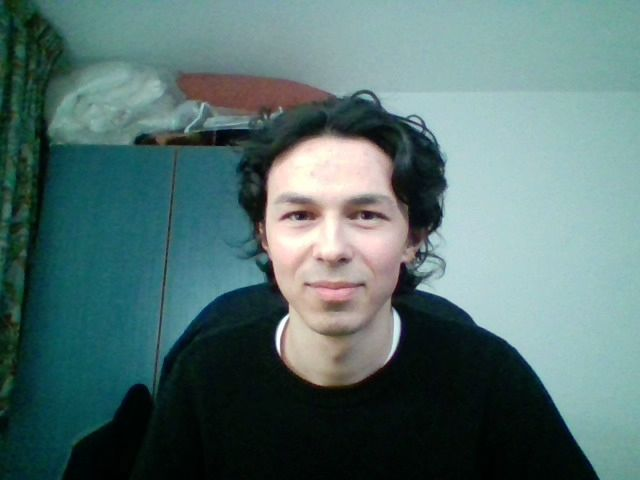

In [32]:
# Start of the user inference (test in real condition of the model)
try:
  firstname = input("Enter your name : ")
  img = take_photo()
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  resized = face_detection_crop(gray, img)
  if resized is not False:
    prediction = inference("svm_model.pkl", resized, 10)

    if prediction == firstname:
      print(f"Access granted ! Welcome {firstname}")
    else:
      print("Access denied.")
  else:
    print("No faces found.")

  # Show the image which was just taken.
  cv2_imshow(img)
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))